In [8]:
from google.colab import drive
drive.mount('/gdrive/')

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).


In [ ]:
!unzip /gdrive/My\ Drive/face\ generation/cropped.zip -d data/
!rm -rf data/__MACOSX

In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
import os
from PIL import Image
dataroot = 'data'

for folders in os.listdir(dataroot):
  for img in os.listdir(os.path.join(dataroot, folders)):
    try:
      im = Image.open(os.path.join(dataroot, folders, img))
    except Exception:
      print('delete', os.path.join(dataroot, folders, img))
      os.remove(os.path.join(dataroot, folders, img))

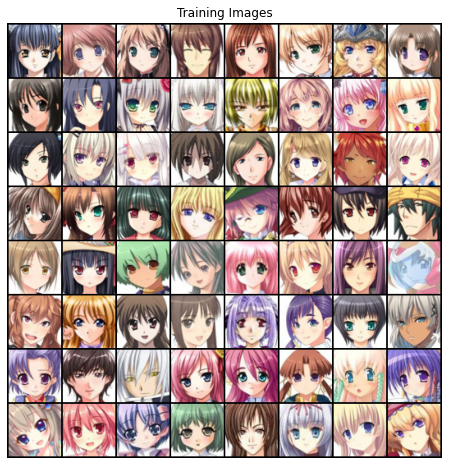

In [70]:

image_size = 64
batch_size = 64
workers = 2
ngpu = 1
d_features = 64
g_features = 64
latent_size = 100
lr = 0.0002
beta1 = 0.5

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [71]:
class Generator(nn.Module):
  def __init__(self, g_features, latent_size):
    super(Generator, self).__init__()
    self.g = g_features
    self.l = latent_size
    self.main = nn.Sequential(
        nn.ConvTranspose2d(self.l, self.g*8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(self.g*8),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(self.g*8, self.g*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.g*4),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(self.g*4, self.g*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.g*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(self.g*2, self.g, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.g),
        nn.ReLU(True),

        nn.ConvTranspose2d(self.g, 3, 4, 2, 1, bias=False),
        nn.Tanh()
    )
  
  def forward(self, input):
    return self.main(input)

class Discriminator(nn.Module):
  def __init__(self, d_features):
    super(Discriminator, self).__init__()
    self.d = d_features
    self.main = nn.Sequential(
        # 3 * 64 * 64
        nn.Conv2d(3, self.d, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.d),
        nn.LeakyReLU(0.2, True),

        # d * 32 * 32
        nn.Conv2d(self.d, self.d*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.d*2),
        nn.LeakyReLU(0.2, True),

        # 2d * 16 * 16
        nn.Conv2d(self.d*2, self.d*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.d*4),
        nn.LeakyReLU(0.2, True),

        # 4d * 8 * 8
        nn.Conv2d(self.d*4, self.d*8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(self.d*8),
        nn.LeakyReLU(0.2, True),

        # 8d * 4 * 4
        nn.Conv2d(self.d*8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )
  
  def forward(self, input):
    return self.main(input)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator(g_features, latent_size).to(device)
D = Discriminator(d_features).to(device)

G.apply(weights_init)
D.apply(weights_init)
print(G, D)

In [73]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [75]:
img_list = []
G_losses = []
D_losses = []
iters = 0
epochs = 10
for epoch in range(epochs):
  for i, data in enumerate(dataloader, 0):

    D.zero_grad()
    real_batch = data[0].to(device)
    label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
    output = D(real_batch).view(-1)
    if output.size() != label.size():
      print(output.size(), label.size())
    D_real_loss = criterion(output, label)
    D_real_loss.backward()
    D_x = output.mean().item()

    noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
    label.fill_(fake_label)
    fake_batch = G(noise)
    output = D(fake_batch.detach()).view(-1)
    D_fake_loss = criterion(output, label)
    D_fake_loss.backward()
    D_G_z1 = output.mean().item()
    D_loss = D_real_loss + D_fake_loss
    optimizerD.step()

    G.zero_grad()
    label.fill_(real_label)
    output = D(fake_batch).view(-1)
    G_loss = criterion(output, label)
    G_loss.backward()
    D_G_z2 = output.mean().item()

    optimizerG.step()

    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        % (epoch, epochs, i, len(dataloader),
        D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
          fake = G(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters += 1

[0/10][0/993]	Loss_D: 0.0000	Loss_G: 37.6627	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][50/993]	Loss_D: 0.0001	Loss_G: 37.1265	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/10][100/993]	Loss_D: 0.0000	Loss_G: 36.4564	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][150/993]	Loss_D: 0.0000	Loss_G: 37.2063	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][200/993]	Loss_D: 0.0000	Loss_G: 33.0388	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][250/993]	Loss_D: 1.0098	Loss_G: 7.5920	D(x): 0.6457	D(G(z)): 0.1895 / 0.0019
[0/10][300/993]	Loss_D: 0.6881	Loss_G: 3.7735	D(x): 0.8311	D(G(z)): 0.3391 / 0.0422
[0/10][350/993]	Loss_D: 1.4991	Loss_G: 8.5473	D(x): 0.9347	D(G(z)): 0.6693 / 0.0007
[0/10][400/993]	Loss_D: 1.2313	Loss_G: 3.5036	D(x): 0.6988	D(G(z)): 0.4924 / 0.0471
[0/10][450/993]	Loss_D: 0.9740	Loss_G: 3.9283	D(x): 0.7664	D(G(z)): 0.4267 / 0.0285
[0/10][500/993]	Loss_D: 1.4215	Loss_G: 7.0351	D(x): 0.8343	D(G(z)): 0.6364 / 0.0023
[0/10][550/993]	Loss_D: 0.6567	Loss_G: 3.1124	D(x): 0.7318	D(G(z)): 0.2330

In [79]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
print(len(img_list))
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

from IPython.display import HTML
HTML(ani.to_jshtml())